In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_disenosyservicios.coma_2733.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_wearzone.netpostdata_1478.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_zapfm.nlohn902b_2134.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_185.65.244.28getinfodata.php_2803.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_mgotto.homepage.t-online.deHJghjb54_2784.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_centerminasph.com.broohbbhbbhbbyinputid.php_1767.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_blogdacomunicacao.com.brimn2index.html_922.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_site_1/phishing_osscamp.plpoeosiasxskksweeoeidppdadoeiidas_1874.png
/kaggle/input/phishing-sites-screenshot/screenshots/phishing_s

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm
import warnings
import pickle
from pathlib import Path
import shutil
warnings.filterwarnings('ignore')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

Using device: cpu


In [3]:
class PhishingImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.labels = []
        
        # Map folder names to labels
        self.class_to_idx = {'genuine_site_0': 0, 'phishing_site_1': 1}
        self.idx_to_class = {0: 'legitimate', 1: 'phishing'}
        
        # Load all images
        for class_name, label in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append(os.path.join(class_name, img_file))
                        self.labels.append(label)
        
        print(f"Found {len(self.samples)} images in {root_dir}")
        print(f"Class distribution:")
        print(f"  Legitimate (0): {sum(1 for x in self.labels if x == 0)}")
        print(f"  Phishing (1): {sum(1 for x in self.labels if x == 1)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.samples[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Load the dataset
dataset_path = '/kaggle/input/phishing-sites-screenshot/screenshots'
full_dataset = PhishingImageDataset(dataset_path, transform=train_transform)

# Split dataset into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform to val dataset
val_dataset.dataset.transform = val_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Found 1697 images in /kaggle/input/phishing-sites-screenshot/screenshots
Class distribution:
  Legitimate (0): 1147
  Phishing (1): 550
Training samples: 1357
Validation samples: 340


In [4]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 8, in_channels, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        ca = self.channel_attention(x)
        return x * ca

class PhishingCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(PhishingCNN, self).__init__()
        
        # Use pre-trained EfficientNet as backbone
        self.backbone = models.efficientnet_b0(pretrained=True)
        in_features = self.backbone.classifier[1].in_features
        
        # Remove the original classifier
        self.backbone.classifier = nn.Identity()
        
        # Attention after backbone features
        self.attention = AttentionModule(in_features)
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate/2),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        
        # Reshape for attention (batch_size, channels, 1, 1)
        features = features.unsqueeze(-1).unsqueeze(-1)
        features = self.attention(features)
        features = features.squeeze(-1).squeeze(-1)
        
        output = self.classifier(features)
        return output

# Initialize model
model = PhishingCNN(num_classes=2).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 173MB/s]


Model parameters: 5,141,662


In [5]:
# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Training configuration
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


FINAL MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.00      0.00      0.00       230
    Phishing       0.32      1.00      0.49       110

    accuracy                           0.32       340
   macro avg       0.16      0.50      0.24       340
weighted avg       0.10      0.32      0.16       340



NameError: name 'train_losses' is not defined

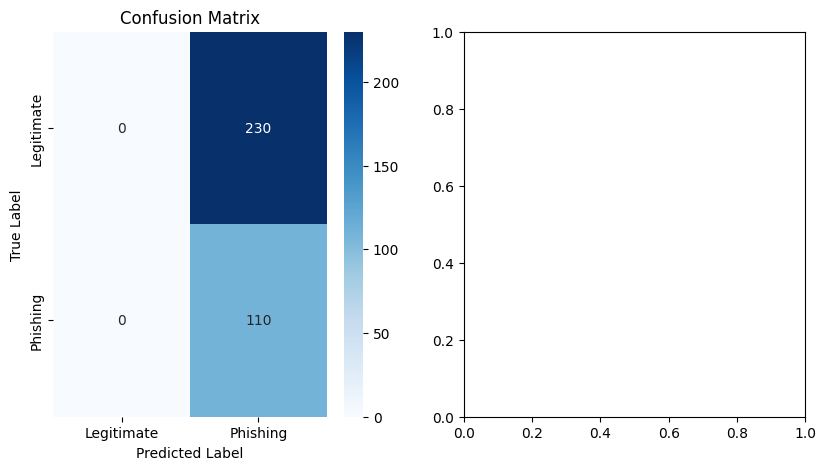

In [6]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_preds, all_labels, all_probs

# Comprehensive evaluation
val_preds, val_labels, val_probs = evaluate_model(model, val_loader)

print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, 
                          target_names=['Legitimate', 'Phishing']))

# Confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Loss curves
plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate additional metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve

auc_roc = roc_auc_score(val_labels, [p[1] for p in val_probs])
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

In [ ]:
# Create a wrapper class for easy inference
class PhishingDetector:
    def __init__(self, model, transform, device):
        self.model = model
        self.transform = transform
        self.device = device
        self.model.eval()
    
    def predict(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.model(image)
            probability = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probability, dim=1).item()
            confidence = probability[0][pred_class].item()
        
        return {
            'prediction': 'phishing' if pred_class == 1 else 'legitimate',
            'confidence': confidence,
            'phishing_probability': probability[0][1].item(),
            'legitimate_probability': probability[0][0].item()
        }

# Create the detector instance
phishing_detector = PhishingDetector(model, val_transform, device)

# Save the complete detector as pickle file
with open('phishing_detector.pkl', 'wb') as f:
    pickle.dump(phishing_detector, f)

print("Model saved as phishing_detector.pkl")

# Also save PyTorch model state for flexibility
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_accuracy': max(val_accuracies) if val_accuracies else 0,
    'transform': val_transform,
    'class_mapping': {'legitimate': 0, 'phishing': 1}
}, 'phishing_model_complete.pth')

print("PyTorch model saved as phishing_model_complete.pth")

In [ ]:
# Test loading the pickle file
def load_and_test_model():
    # Load from pickle
    with open('phishing_detector.pkl', 'rb') as f:
        loaded_detector = pickle.load(f)
    
    print("Model loaded successfully from pickle!")
    
    # Test on a few sample images
    test_samples = []
    for class_name in ['genuine_site_0', 'phishing_site_1']:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.exists(class_dir):
            images = os.listdir(class_dir)[:2]  # Take first 2 images from each class
            for img in images:
                test_samples.append((os.path.join(class_dir, img), class_name))
    
    print("\nTesting loaded model on sample images:")
    for img_path, true_class in test_samples:
        result = loaded_detector.predict(img_path)
        print(f"Image: {os.path.basename(img_path)}")
        print(f"  True: {true_class}")
        print(f"  Pred: {result['prediction']} (conf: {result['confidence']:.4f})")
        print(f"  Phishing prob: {result['phishing_probability']:.4f}")
        print()

# Run the test
load_and_test_model()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm
import warnings
import pickle
from pathlib import Path
import shutil
warnings.filterwarnings('ignore')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class PhishingImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.labels = []
        
        # Map folder names to labels
        self.class_to_idx = {'genuine_site_0': 0, 'phishing_site_1': 1}
        self.idx_to_class = {0: 'legitimate', 1: 'phishing'}
        
        # Load all images
        for class_name, label in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append(os.path.join(class_name, img_file))
                        self.labels.append(label)
        
        print(f"Found {len(self.samples)} images in {root_dir}")
        print(f"Class distribution:")
        print(f"  Legitimate (0): {sum(1 for x in self.labels if x == 0)}")
        print(f"  Phishing (1): {sum(1 for x in self.labels if x == 1)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.samples[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Load the dataset
print("Loading dataset...")
dataset_path = '/kaggle/input/phishing-sites-screenshot/screenshots'
full_dataset = PhishingImageDataset(dataset_path, transform=train_transform)

# Split dataset into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform to val dataset
val_dataset.dataset.transform = val_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Enhanced CNN Model
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 8, in_channels, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        ca = self.channel_attention(x)
        return x * ca

class PhishingCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(PhishingCNN, self).__init__()
        
        # Use pre-trained EfficientNet as backbone
        self.backbone = models.efficientnet_b0(pretrained=True)
        in_features = self.backbone.classifier[1].in_features
        
        # Remove the original classifier
        self.backbone.classifier = nn.Identity()
        
        # Attention after backbone features
        self.attention = AttentionModule(in_features)
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate/2),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        
        # Reshape for attention (batch_size, channels, 1, 1)
        features = features.unsqueeze(-1).unsqueeze(-1)
        features = self.attention(features)
        features = features.squeeze(-1).squeeze(-1)
        
        output = self.classifier(features)
        return output

# Initialize model
print("Initializing model...")
model = PhishingCNN(num_classes=2).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Training configuration
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training Loop
def train_model(model, train_loader, val_loader, epochs=25):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    early_stopping = EarlyStopping(patience=5)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100*correct/total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Update learning rate
        scheduler.step()
        
        # Early stopping check
        early_stopping(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    return train_losses, val_losses, val_accuracies, all_preds, all_labels

# Start training
print("Starting training...")
train_losses, val_losses, val_accuracies, val_preds, val_labels = train_model(
    model, train_loader, val_loader, epochs=25
)

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_preds, all_labels, all_probs

# Comprehensive evaluation
print("Evaluating model...")
val_preds, val_labels, val_probs = evaluate_model(model, val_loader)

print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, 
                          target_names=['Legitimate', 'Phishing']))

# Confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Loss curves
plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate additional metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve

auc_roc = roc_auc_score(val_labels, [p[1] for p in val_probs])
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Create a wrapper class for easy inference
class PhishingDetector:
    def __init__(self, model, transform, device):
        self.model = model
        self.transform = transform
        self.device = device
        self.model.eval()
    
    def predict(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.model(image)
            probability = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probability, dim=1).item()
            confidence = probability[0][pred_class].item()
        
        return {
            'prediction': 'phishing' if pred_class == 1 else 'legitimate',
            'confidence': confidence,
            'phishing_probability': probability[0][1].item(),
            'legitimate_probability': probability[0][0].item()
        }

# Create the detector instance and save as pickle
print("Saving model...")
phishing_detector = PhishingDetector(model, val_transform, device)

# Save the complete detector as pickle file
with open('phishing_detector.pkl', 'wb') as f:
    pickle.dump(phishing_detector, f)

print("Model saved as phishing_detector.pkl")

# Also save PyTorch model state for flexibility
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_accuracy': max(val_accuracies) if val_accuracies else 0,
    'transform': val_transform,
    'class_mapping': {'legitimate': 0, 'phishing': 1}
}, 'phishing_model_complete.pth')

print("PyTorch model saved as phishing_model_complete.pth")

# Test loading the pickle file
def load_and_test_model():
    # Load from pickle
    with open('phishing_detector.pkl', 'rb') as f:
        loaded_detector = pickle.load(f)
    
    print("Model loaded successfully from pickle!")
    
    # Test on a few sample images
    test_samples = []
    for class_name in ['genuine_site_0', 'phishing_site_1']:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.exists(class_dir):
            images = os.listdir(class_dir)[:2]  # Take first 2 images from each class
            for img in images:
                test_samples.append((os.path.join(class_dir, img), class_name))
    
    print("\nTesting loaded model on sample images:")
    for img_path, true_class in test_samples:
        result = loaded_detector.predict(img_path)
        print(f"Image: {os.path.basename(img_path)}")
        print(f"  True: {true_class}")
        print(f"  Pred: {result['prediction']} (conf: {result['confidence']:.4f})")
        print(f"  Phishing prob: {result['phishing_probability']:.4f}")
        print()

# Run the test
load_and_test_model()

print("\nTraining and evaluation completed successfully!")